## In this TD, we explore a well-known method for inpainting. 
 This method is called non-local means and use the redundant information to denoise or perform the inpainting. The proposed implementation is however far from being state of the art.

In [1]:
from __future__ import division
from  imageio import imwrite 
%pylab inline
import numpy as np
import scipy as sp
import scipy.fftpack as ft


Populating the interactive namespace from numpy and matplotlib


(128, 128, 3)
mean:  136.9349365234375 
standart deviation:  55.59281495266457 
valeur min:  1.0
im shape (128, 128)


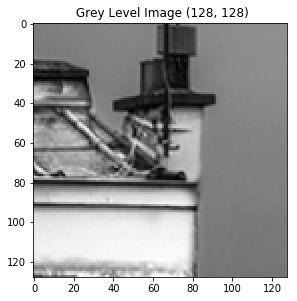

In [2]:
# load an image
import imageio as imio
colored_image = imio.imread('toit.PNG')
print(colored_image.shape)
n = colored_image.shape[0]-1
n = 128
image = np.sum(colored_image*[0.21, 0.72 ,0.07],axis=-1) #[n:2*n,100:100+n]

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.gray()
#cropped = image[n:n+64,n:n + 64]
plt.title(" Grey Level Image " + str(np.shape(image)))
cropped = image
plt.imshow(image)
print("mean: ",np.mean(cropped),"\nstandart deviation: ",np.std(cropped),"\nvaleur min: ",(np.min(cropped)))
print("im shape",image.shape)
image0 = np.copy(image)

### We define the snr and several types of noise.

-0.0


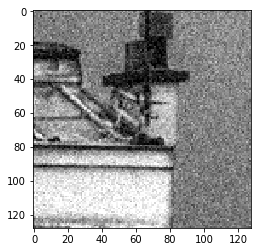

In [3]:
def snr(x, y): # signal noise ratio
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)
def clamp0(x):
    temp =  255*(x>255) + x * (x<255) 
    return temp * (x>0)
def clamp(x,a,b):
    temp = b*(x>b) + x * (x<b)  
    result = temp*(temp>a) + a*(x<a)
    return result
def GaussianNoise(image,sigma):
    return clamp0(image + sigma*np.random.randn(image.shape[0],image.shape[1]))

def SaltNoise(image,sigma):
    return clamp0(image + sigma*(np.random.randn(image.shape[0],image.shape[1])>0))

sigma = 20.0
noisy_image  = clamp0(image + sigma*np.random.randn(image.shape[0],image.shape[1]))
#noisy_image = denoised1
print(np.min(noisy_image))
plt.imshow(noisy_image)
#np.random.randn 0 means and var 1  * sigma for blanc noise and mu=0

### In the cell below, we construct an array that codes for the coordinates of the patches.

In [4]:
half_taille_patch = 3
taille_patch = 2*half_taille_patch + 1
[X,Y,dX,dY] = np.meshgrid(np.arange(1,n+1),np.arange(1,n+1),np.arange(-half_taille_patch,half_taille_patch+1),np.arange(-half_taille_patch,half_taille_patch+1))
#print(Y) 
# X est une range 0-127 de 1 puis 2 [...] jusqu'à N et ensuite on rajoute dX une range -3;3 (-N;N)
# X représente les coefs par lignes
# de même pour Y les coefs par lignes et dY

X = X + dX # x coordinate
Y = Y + dY # y coordinate
# hereafter we deal with the boundaries.
X[X < 1] = 2-X[X < 1] #miroir sur X[i<0]
Y[Y < 1] = 2-Y[Y < 1] #miroir sur Y[i<0]
X[X > n] = 2*n-X[X > n] #miroir sur X[i>n]
Y[Y > n] = 2*n-Y[Y > n] #miroir sur X[i>n]
print(np.meshgrid(np.arange(1,4),np.arange(1,4)))
print(X[120][127])


[array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]]), array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])]
[[125 125 125 125 125 125 125]
 [126 126 126 126 126 126 126]
 [127 127 127 127 127 127 127]
 [128 128 128 128 128 128 128]
 [127 127 127 127 127 127 127]
 [126 126 126 126 126 126 126]
 [125 125 125 125 125 125 125]]


### Dans le cas ou on est sur les bords ici le choix à été de faire un miroir des pixels ce situant sur les bords.

### We collect the patches below using $I$ which collects the coordinates defining the patches.

In [5]:
I = (X-1) + (Y-1)*n
print("size of the array I ",I.shape)
for i in range(n//half_taille_patch): # // division entière
    for j in range(n//half_taille_patch):
        I[i,j] = np.transpose(I[i,j])
        #print(I[i,j],"\n")
patch = lambda f: np.ravel(f)[I] #ravel: concatenation
P = patch(noisy_image)
#P = patch(image )

# on applique la décomposition par patch I à l'image qui est d'abord concaténé.

size of the array I  (128, 128, 7, 7)


### Question 1: what happens for the patches on the boundary of the image for the patches ?

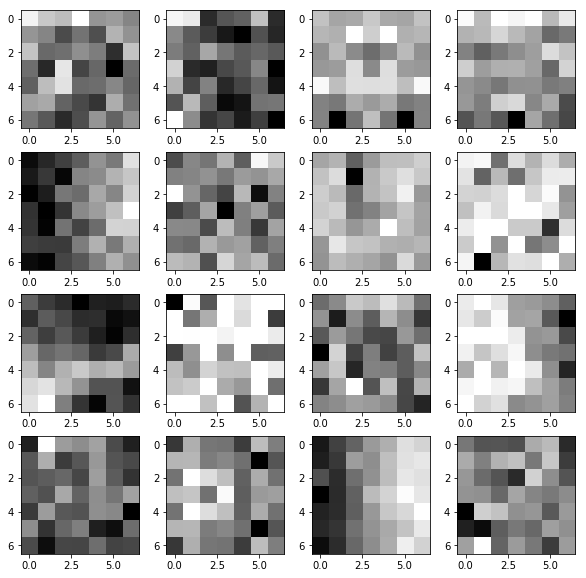

Patch en I[0,0]


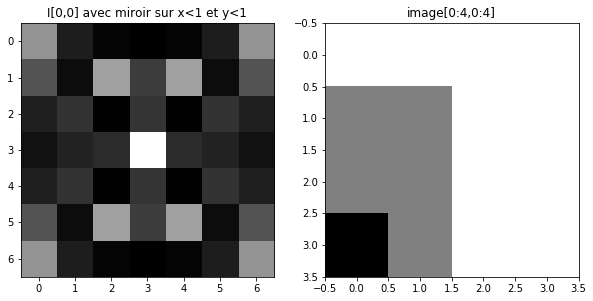

In [6]:
### some random patches.
plt.figure(figsize = (10,10))
for i in range(16):
    x = np.random.randint(n)
    y = np.random.randint(n)
    plt.subplot(4,4,i+1)
    plt.imshow(P[x, y])
#plt.imshow(P[127, 127])
#plt.show()
#plt.figure(figsize = (10,10))
#plt.imshow(P[127, 0])
plt.show()
print("Patch en I[0,0]")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title("I[0,0] avec miroir sur x<1 et y<1")
plt.imshow(P[0,0])
plt.subplot(1,2,2)
plt.title("image[0:4,0:4]")
plt.imshow(image[0:4,0:4])
plt.show()

## 2. Dimensionality reduction using PCA: Principal Component Analysis.
We have collected a large number of patches and we would like to represent this collection of patches by a simple known distribution that approximates it. The PCA method uses a gaussian approximation. Note that the size of a patch is $6^2$ or $8^2$, so that we want to reduce the dimension to $15$ or a bit more.
The PCA algorithm finds a linear subspace of dimension $k$, which is chosen by the user, that minimizes the distances of data with respect to this subspace.

In [7]:
dimension = 25
# a reshape function
resh = lambda P: np.transpose((np.reshape(P, (n*n,taille_patch**2), order="F")))
# remove mean is a preparation for PCA.
remove_mean = lambda Q: Q - np.tile(np.mean(Q,0),(taille_patch**2,1))
# np.tile :Construct an array by repeating A the number of times given by reps.
# np.mean(Q,axis=0) axis==0 -> a = np.array([[1, 2], [3, 4]]) -> array([2., 3.])
#                   axis==1 -> array([1.5, 3.5])
P1 = remove_mean(resh(P)) # P = patch(image) 
C = np.dot(P1,np.transpose(P1))

#### What is used below is a method in linear algebra called Singular Value Decomposition «SVD», and gives the subspaces being spanned by the first $k$ eigenvectors corresponding to the $k$ largest eigenvalues of the decomposition. 

In [8]:
[D,V] = np.linalg.eig(C)
# the array D is the list of eigenvalues and the arry V is the corresponding eigenvectors.
# We then sort the values in decreasing order and reindex the corresponding eigenvectors.
D = np.sort(D)[::-1] #eingenvalues sorted
I = np.argsort(D)[::-1] # argosort renvoie la position des egeinvalue sorted
V = V[I,:] # renvoie les eigein vecteur en fonction de la valeur décroissante des eigeinvalue
# L = range(10)
#L[::-1] -> [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


### Question 2: 
#### 1. Plot the decreasing eigenvalues and decide how many eigenvectors are representative of the distribution of the patches under this gaussian assumption. 
#### 2. Check the L2 norm of the eigenvectors.
#### 3. Plot the corresponding eigenvectors which represent the main modes of variation of the patches.

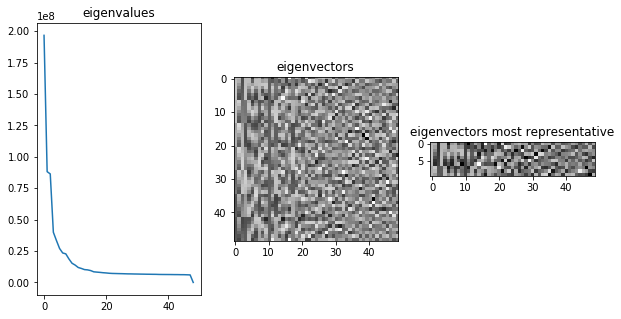

oui


In [9]:
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.title("eigenvalues")
plt.plot(D)
plt.subplot(1,3,2)
plt.title("eigenvectors")
plt.imshow(V)
MainEigenvalues = V[0:10]
plt.subplot(1,3,3)
plt.title("eigenvectors most representative")
plt.imshow(MainEigenvalues)
plt.show()
print("oui")

In [10]:
iresh = lambda Q: np.reshape(np.transpose(Q),(n,n,dimension),order="F")
H = iresh(np.dot(np.transpose(V[: ,:dimension]),remove_mean(resh(P)))) #pscalair V et P reshape
print (np.transpose(V[: ,:dimension]).shape,remove_mean(resh(P)).shape)
print (H.shape)
#dimension =25

(25, 49) (49, 16384)
(128, 128, 25)


In [11]:
# Create the gaussian kernel on patches
distance = lambda i: np.sum((H - np.tile(H[i[0],i[1],:], (n,n,1)))**2, 2)/(taille_patch**2)
normalize = lambda K: K/np.sum(K)
kernel = lambda i,tau: normalize(np.exp(-distance(i)/(2*tau**2)))

In [12]:
# Some parameters and an example
tau = 10.0
i = [85,40]
D = distance(i)
K = kernel(i, tau)

#### Question 3: Explain what is shown below ?

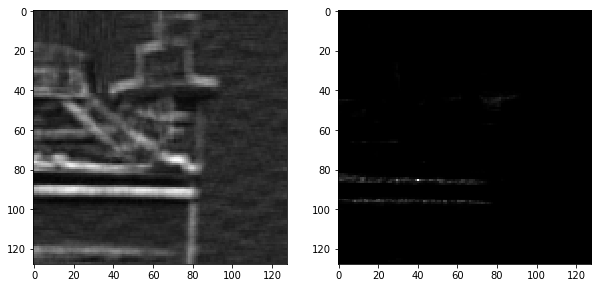

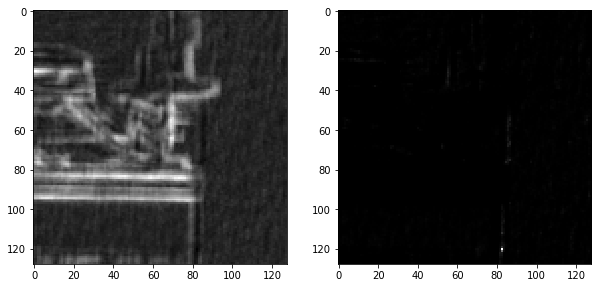

In [13]:
# Some parameters and an example
tau = 10.0
i = [85,40]
D = distance(i)
K = kernel(i, tau)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(D) #image des distances
plt.subplot(1,2,2)
plt.imshow(K) #gaussian kernel associated with D&i
plt.show() # for pixel (y=85 and x = 40 ) represente the most similar detail in the image

tau = 10.0
i = [120,82]
D = distance(i)
K = kernel(i, tau)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(D) #image des distances
plt.subplot(1,2,2)
plt.imshow(K) #gaussian kernel associated with D&i
plt.show() # for pixel (y=85 and x = 40 ) represente the most similar detail in the image

In [14]:
# Selection of the parameter that select a range of patches in order to fasten the computations so in fact 
# the algorithm is a bit more local...
q = 14

In [15]:
selection = lambda i: np.array((clamp(np.arange(i[0]-q,i[0] + q + 1), 0, n-1), clamp(np.arange(i[1]-q,i[1] + q + 1), 0, n-1)))
# on vient regarder non plus toute l'image mais une range de -q à q dans laquel on regarde les patchs
# sinon sur toute l'image la complexité est trop importante

In [16]:
def distance_0(i,sel): 
    H1 = (H[sel[0],:,:])
    H2 = (H1[:,sel[1],:])
    return np.sum((H2 - np.tile(H[i[0],i[1],:],(len(sel[0]),len(sel[1]),1)))**2,2)/(taille_patch**2)
normalize = lambda K: K/np.sum(K)
distance = lambda i: distance_0(i, selection(i))
kernel = lambda i, tau: normalize(np.exp(-distance(i)/ (2*tau**2)))


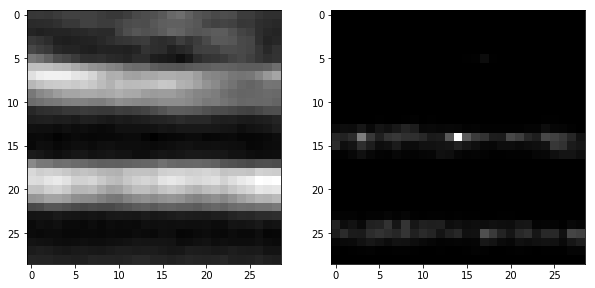

In [17]:
i = [85,40]
D = distance(i)
K = kernel(i, tau)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(D)
plt.subplot(1,2,2)
plt.imshow(K)
plt.show()

In [18]:
def NLval_0(K,sel): 
    f_temp = noisy_image[sel[0],:]
    return np.sum(K*f_temp[:, sel[1]]) #mutltiplication kernel * noisy image

NLval = lambda i, tau: NLval_0(kernel(i, tau), selection(i))

#### Question 4: Understand the code below.

snr(image,imgdenoised) 21.006978978447897


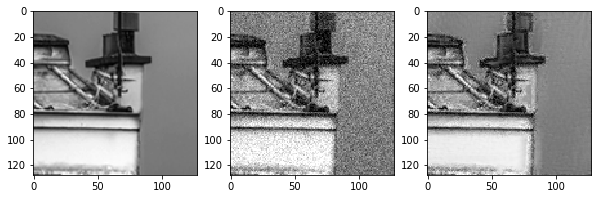

In [19]:
[Y, X] = np.meshgrid(np.arange(0,n),np.arange(0,n))

def arrayfun(img,X,Y):
    n = len(X)
    p = len(Y)
    R = np.zeros([n,p])
    for k in range(n):
        for l in range(p):
            R[k,l] = img(k,l)
    return R

NLmeans = lambda tau: arrayfun(lambda i1, i2: NLval([i1,i2], tau), X, Y)
#rangetau=30
#snr_result=[0]*rangetau
#for tau in range(0,rangetau):
#    imgdenoised = NLmeans(tau)
#    snr_= snr(image,imgdenoised)
#    print("snr(image,imgdenoised) (tau =",tau,"): " ,snr_)
#    snr_result[tau]=snr_
tau=7
imgdenoised = NLmeans(tau)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(noisy_image)
plt.subplot(1,3,3)
plt.imshow(imgdenoised)
print("snr(image,imgdenoised)",snr(image,imgdenoised))

[nan, 17.603420506790165, 17.60348645246212, 17.628698058826394, 18.09902566336656, 19.485562606281714, 20.524547388912815, 20.89116719773836, 20.840756643729662, 20.507749029720177, 19.986709570050067, 19.35965751537526, 18.70772789177049, 18.093437574333482, 17.548155512930382, 17.077708683058127, 16.676387324959762, 16.336519697046693, 16.049464801987522, 15.805454809141121, 15.594835739600352, 15.40939723061947, 15.242965351832154, 15.09131828176534, 14.951759156349231, 14.822620775202108, 14.702849258393996, 14.591713275067661, 14.4886288419255, 14.393068400979153] <br/>

Pour tau allant de 0 a 30

Max pour tau =  7  -> snr = 20.89116719773836


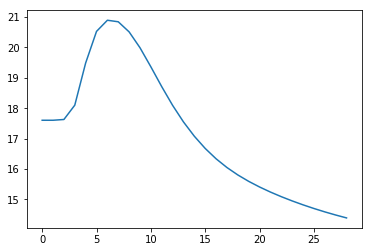

In [20]:
snr_result=[ 17.603420506790165, 17.60348645246212, 17.628698058826394, 18.09902566336656, 19.485562606281714, 20.524547388912815, 20.89116719773836, 20.840756643729662, 20.507749029720177, 19.986709570050067, 19.35965751537526, 18.70772789177049, 18.093437574333482, 17.548155512930382, 17.077708683058127, 16.676387324959762, 16.336519697046693, 16.049464801987522, 15.805454809141121, 15.594835739600352, 15.40939723061947, 15.242965351832154, 15.09131828176534, 14.951759156349231, 14.822620775202108, 14.702849258393996, 14.591713275067661, 14.4886288419255, 14.393068400979153]
print("Max pour tau = " ,np.argmax(snr_result)+1 ," -> snr =" ,np.max(snr_result))
plt.plot(snr_result)

#### Question 5: Find the optimal parameters for denoising the image to obtain the highest possible SNR. 

#### Question 6: Compare with cycle spinning wavelet denoiser.